In [40]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import glob
import numpy as np
import tqdm

In [6]:
batch_size = 32
img_height = 128
img_width = 128

In [7]:
X_train = []
for img in tqdm.tqdm(glob.glob("../data/derived_data/data_augmented/train/*.npy")):
    X_train.append(np.load(img)[np.newaxis,:,:,:])

100%|██████████| 8019/8019 [00:01<00:00, 7653.32it/s]


In [8]:
X_train = np.concatenate(X_train)

In [17]:
labels = [l.split("/")[-1].split("_")[0] for l in sorted(glob.glob("../data/derived_data/data_augmented/train/*"))]

In [29]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "../data/derived_data/data_augmented/",
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    validation_split=0.2,
    subset="training",
    image_size=(img_width, img_height),
    shuffle=True,
    seed=0,
)

Found 11456 files belonging to 716 classes.
Using 9165 files for training.


In [30]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    "../data/derived_data/data_augmented/",
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    image_size=(img_width, img_height),
    shuffle=True,
    seed=0,
)

Found 11456 files belonging to 716 classes.
Using 2291 files for validation.


In [33]:
class_names = train_dataset.class_names

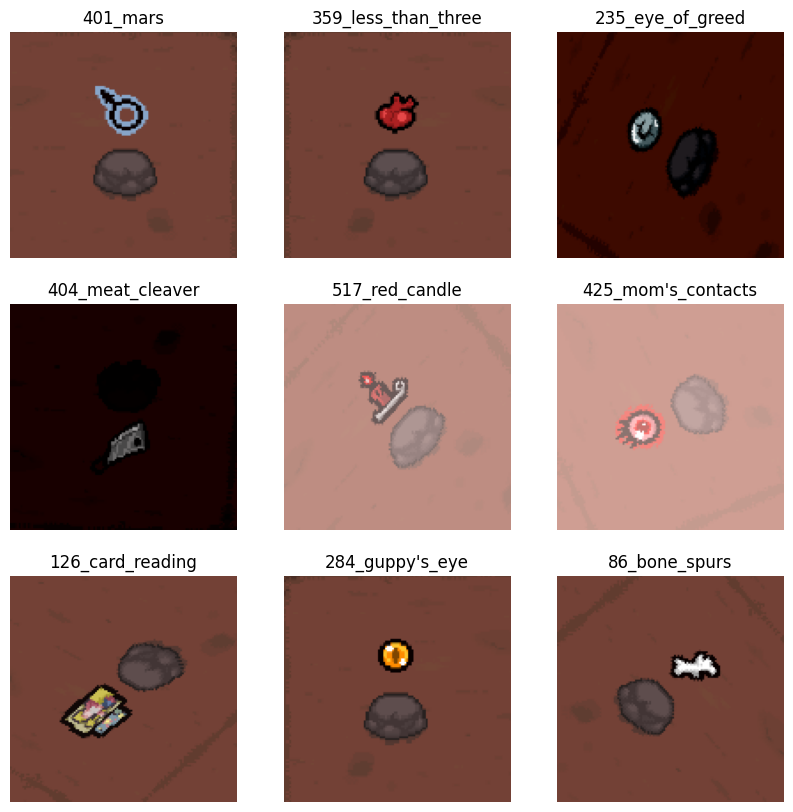

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [37]:
normalization_layer = layers.Rescaling(1./255)

In [38]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [41]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [48]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
287/287 [==============================] - 19s 66ms/step - loss: 0.2063 - accuracy: 0.9427 - val_loss: 3.7487 - val_accuracy: 0.6430
Epoch 2/20
287/287 [==============================] - 19s 68ms/step - loss: 0.1800 - accuracy: 0.9523 - val_loss: 3.9849 - val_accuracy: 0.6320
Epoch 3/20
287/287 [==============================] - 23s 81ms/step - loss: 0.1595 - accuracy: 0.9583 - val_loss: 4.1616 - val_accuracy: 0.6390
Epoch 4/20
287/287 [==============================] - 23s 80ms/step - loss: 0.1158 - accuracy: 0.9684 - val_loss: 4.2478 - val_accuracy: 0.6464
Epoch 5/20
287/287 [==============================] - 23s 81ms/step - loss: 0.1579 - accuracy: 0.9585 - val_loss: 4.3177 - val_accuracy: 0.6299
Epoch 6/20
287/287 [==============================] - 24s 82ms/step - loss: 0.1441 - accuracy: 0.9673 - val_loss: 4.2561 - val_accuracy: 0.6473
Epoch 7/20
287/287 [==============================] - 23s 80ms/step - loss: 0.0830 - accuracy: 0.9787 - val_loss: 4.4623 - val_accuracy:

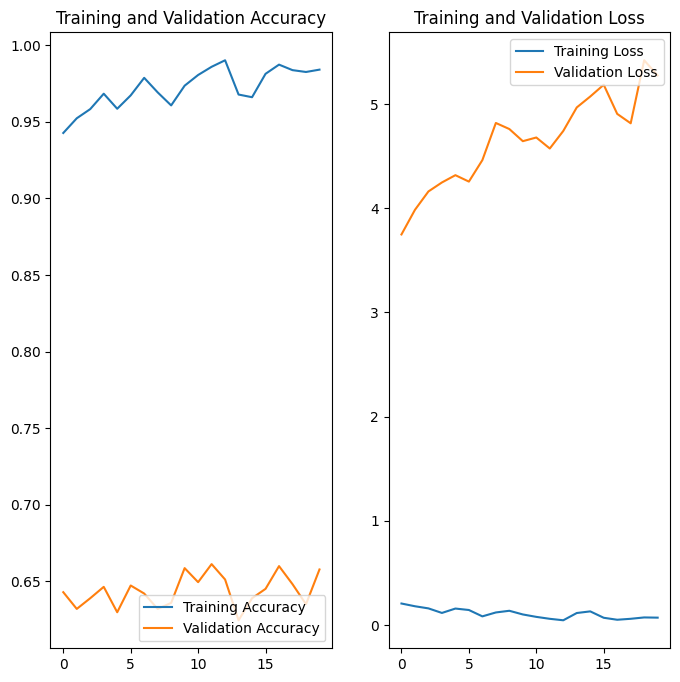

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [58]:
img = tf.keras.utils.load_img(
    "/home/mizunno/Projects/TBOI_item_detector/data/derived_data/data_augmented/652_the_mulligan/652_the_mulligan_5.png", target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 26ms/step
This image most likely belongs to 652_the_mulligan with a 100.00 percent confidence.
